### Read Dataset

In [1]:
!unzip MLA_100k_checked_v3.jsonlines.zip

Archive:  MLA_100k_checked_v3.jsonlines.zip
  inflating: MLA_100k_checked_v3.jsonlines  
  inflating: __MACOSX/._MLA_100k_checked_v3.jsonlines  


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

from catboost import CatBoostClassifier
from sklearn import metrics


# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k_checked_v3.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = build_dataset()

In [4]:
X_train[0]

{'accepts_mercadopago': True,
 'attributes': [],
 'automatic_relist': False,
 'available_quantity': 1,
 'base_price': 80.0,
 'buying_mode': 'buy_it_now',
 'catalog_product_id': None,
 'category_id': 'MLA126406',
 'condition': 'new',
 'coverage_areas': [],
 'currency_id': 'ARS',
 'date_created': '2015-09-05T20:42:53.000Z',
 'deal_ids': [],
 'descriptions': ["{'id': 'MLA4695330653-912855983'}"],
 'differential_pricing': None,
 'id': 'MLA4695330653',
 'initial_quantity': 1,
 'international_delivery_mode': 'none',
 'last_updated': '2015-09-05T20:42:58.000Z',
 'listing_source': '',
 'listing_type_id': 'bronze',
 'non_mercado_pago_payment_methods': [{'description': 'Transferencia bancaria',
   'id': 'MLATB',
   'type': 'G'},
  {'description': 'Acordar con el comprador', 'id': 'MLAWC', 'type': 'G'},
  {'description': 'Efectivo', 'id': 'MLAMO', 'type': 'G'}],
 'official_store_id': None,
 'original_price': None,
 'parent_item_id': 'MLA6553902747',
 'permalink': 'http://articulo.mercadolibre.com

In [5]:
# first we parse the json in a nested dataframe, to convert dicts into new colums i.e -> seller_address TRANSFORM INTO seller_address_city, seller_address_country_name, etc.. 

from pandas.io.json._normalize import nested_to_record    

flat_Train = nested_to_record(X_train, sep='_')
X_train = pd.DataFrame(flat_Train)
print(f'X_train shape {X_train.shape}')


flat_Test = nested_to_record(X_test, sep='_')
X_test = pd.DataFrame(flat_Test)
print(f'X_test shape {X_test.shape}')


X_train shape (90000, 56)
X_test shape (10000, 55)


In [6]:
# first row 
X_train.head(1).T

,0
warranty,None
sub_status,[]
condition,new
deal_ids,[]
base_price,80.0
non_mercado_pago_payment_methods,"[{'description': 'Transferencia bancaria', 'id..."
seller_id,8208882349
variations,[]
site_id,MLA
listing_type_id,bronze


In [7]:
#convert target labels to DF and encode {new = 0, used = 1}

y_train = pd.DataFrame(y_train, columns = ['label'])
y_train = y_train.replace('used', 1)
y_train = y_train.replace('new', 0)

y_test = pd.DataFrame(y_test, columns = ['label'])
y_test = y_test.replace('used', 1)
y_test = y_test.replace('new', 0)

### First we are see the distribution of the target labels to understand if it's a unbalanced dataset problem and a brief describe about our data in X


#### Train label distribution

%PERCENT: 
0    0.54
1    0.46
Name: label, dtype: float64 

#QTY: 
0    48352
1    41648
Name: label, dtype: int64


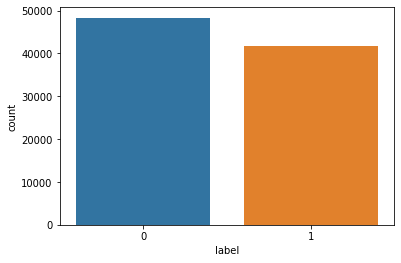

In [8]:
sns.countplot(data = y_train, x = 'label')

print(f'%PERCENT: \n{np.round(y_train.label.value_counts(normalize = True),2)} \n')
print(f'#QTY: \n{np.round(y_train.label.value_counts(),2)}')

#### X_train distribution

In [9]:
pd.set_option('display.float_format',lambda x:'%.3f'% x) #remove scientific notation

X_train.describe()

,base_price,seller_id,price,official_store_id,original_price,stop_time,catalog_product_id,initial_quantity,start_time,sold_quantity,available_quantity
count,90000.000,90000.000,90000.000,745.000,130.000,90000.000,7.000,90000.000,90000.000,90000.000,90000.000
mean,57813.408,5487385581.631,57813.518,5802.019,1492.522,1447647931597.030,2895699.714,34.957,1442383079673.645,2.328,34.701
std,9089554.788,2587139971.316,9089554.787,2657.056,1954.906,3251039539.911,1919770.660,421.092,2122682557.638,33.839,420.812
min,0.840,1000319478.000,0.840,1024.000,120.000,1444823497000.000,94404.000,1.000,1369110155000.000,0.000,1.000
25%,90.000,3184874639.000,90.000,3590.000,449.000,1446313250500.000,1925517.500,1.000,1441144008000.000,0.000,1.000
50%,250.000,5512495978.500,250.000,6158.000,850.000,1447642884500.000,3051112.000,1.000,1442523935000.000,0.000,1.000
75%,800.000,7704929703.000,800.000,8216.000,1500.000,1448930340750.000,4073615.000,2.000,1443799717250.000,0.000,2.000
max,2222222222.000,9999852737.000,2222222222.000,9996.000,12248.000,1730732151000.000,5126117.000,9999.000,1444900470000.000,6065.000,9999.000


In [10]:
# if the mean price arround in 60k maybe we have some outliers on the price column, then we replace with the mean. 

In [11]:
X_train['price'].where(X_train['price'] > 4000000).value_counts()

11111111.000      3
1111111111.000    2
5330000.000       1
8888888.000       1
2222222222.000    1
9000000.000       1
123456789.000     1
112111111.000     1
6500000.000       1
Name: price, dtype: int64

In [12]:
X_train.loc[X_train.price > 4000000, 'price'] = X_train['price'].mean()

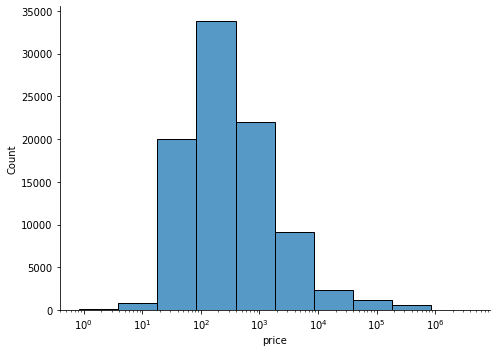

In [13]:
sns.displot(
  data=X_train,
  x="price",
  kind="hist",
  aspect=1.4,
  log_scale=10,
  bins=10
)

#### Test label distribution

%PERCENT: 
0   0.540
1   0.460
Name: label, dtype: float64 

#QTY: 
0    5406
1    4594
Name: label, dtype: int64


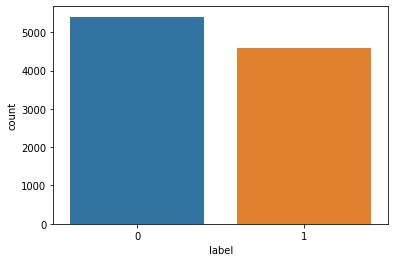

In [14]:
sns.countplot(data = y_test, x = 'label')

print(f'%PERCENT: \n{np.round(y_test.label.value_counts(normalize = True),2)} \n')
print(f'#QTY: \n{np.round(y_test.label.value_counts(),2)}')

#### X_test distribution

In [16]:
X_test.describe()

,base_price,seller_id,price,official_store_id,original_price,stop_time,catalog_product_id,initial_quantity,start_time,sold_quantity,available_quantity
count,10000.000,10000.000,10000.000,73.000,13.000,10000.000,4.000,10000.000,10000.000,10000.000,10000.000
mean,4921.612,5519016039.555,4921.618,5649.164,2601.538,1447628522581.730,5183544.250,36.319,1442377384236.800,3.018,36.117
std,38379.886,2594587576.723,38379.885,2700.911,4169.966,3226534111.674,167577.079,420.953,2038148343.973,88.964,420.798
min,1.000,1000078989.000,1.000,1330.000,350.000,1444897728000.000,5093232.000,1.000,1375882909000.000,0.000,1.000
25%,92.925,3245125148.500,92.925,3590.000,599.000,1446291993750.000,5093232.000,1.000,1441121454500.000,0.000,1.000
50%,250.000,5563425521.500,250.000,5192.000,889.000,1447621138000.000,5103216.000,1.000,1442501645000.000,0.000,1.000
75%,875.982,7740857933.750,875.982,8649.000,1225.000,1448931111500.000,5193528.250,2.000,1443801761500.000,0.000,2.000
max,1499000.000,9999735017.000,1499000.000,9971.000,13999.000,1730732151000.000,5434513.000,9999.000,1444899305000.000,8676.000,9999.000


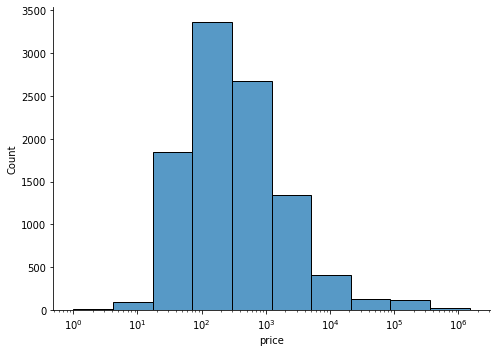

In [15]:
sns.displot(
  data=X_test,
  x="price",
  kind="hist",
  aspect=1.4,
  log_scale=10,
  bins=10
)

## EDA 

In [16]:
quantitative_vars = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

In [17]:
for col in quantitative_vars:
    print(col,':')
    print(X_train[col].value_counts(), '\n')

base_price :
50.000      2920
100.000     2562
150.000     2242
60.000      1859
200.000     1789
            ... 
924.520        1
4399.990       1
6374.000       1
179.070        1
696.580        1
Name: base_price, Length: 9594, dtype: int64 

seller_id :
5248662274    850
2015548469    654
7704929703    424
4631246902    408
8612126795    318
             ... 
1941984304      1
9133610243      1
6259088162      1
9621113308      1
9518711314      1
Name: seller_id, Length: 33281, dtype: int64 

price :
50.000      2920
100.000     2562
150.000     2242
60.000      1859
200.000     1789
            ... 
4399.990       1
6374.000       1
179.070        1
6242.000       1
696.580        1
Name: price, Length: 9587, dtype: int64 

official_store_id :
1580.000    37
6448.000    27
6732.000    23
4701.000    21
9218.000    20
            ..
7532.000     1
6106.000     1
8293.000     1
7248.000     1
4338.000     1
Name: official_store_id, Length: 193, dtype: int64 

original_price :
750.

In [20]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

#scaler

scaler = StandardScaler()
scaler.fit(X_train[numeric_features])
X_train[numeric_features]  = scaler.transform(X_train[numeric_features])

X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [21]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

cols_common = [X_train.columns[i] for i in range(len(X_train.columns))]

## Feature Correlations

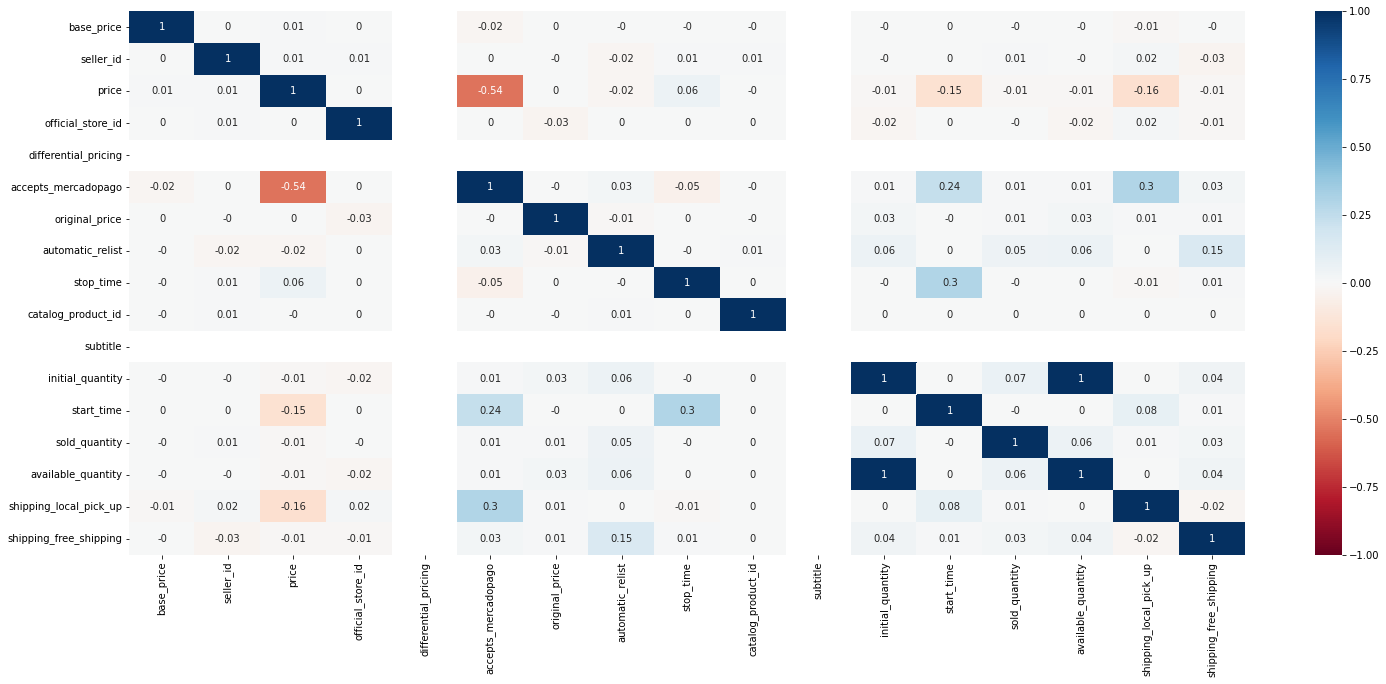

In [22]:
plt.figure(figsize = (25,10))

sns.heatmap(X_train[cols_common].corr().round(2),
            vmin = -1,
            vmax = 1,
            annot = True,
            cmap = 'RdBu')

plt.savefig(f'correlations.jpg')
plt.show()

In [23]:
# Drop columns with object-list into cell. In a second version we parse this fields to enrich the model. 

In [24]:
X_train.drop(['condition', 'shipping_tags', 'shipping_methods', 'pictures', 'descriptions', 'coverage_areas', 'sub_status',
              'deal_ids','non_mercado_pago_payment_methods','variations','attributes','tags','shipping_free_methods'], axis=1, inplace=True)

In [25]:
X_test.drop(['shipping_tags', 'shipping_methods', 'pictures', 'descriptions', 'coverage_areas', 'sub_status',
              'deal_ids','non_mercado_pago_payment_methods','variations','attributes','tags','shipping_free_methods'], axis=1, inplace=True)

## Model Train

In [26]:
catboost_params = {'iterations': 300,
        'learning_rate': 0.1,
        'eval_metric': 'F1',
        'l2_leaf_reg': 0.5,
        'use_best_model':True,
        'early_stopping_rounds':30,
        "loss_function": "Logloss",
        }

In [27]:
model = CatBoostClassifier(**catboost_params, random_state = 0)

In [28]:
X_train_2_sorted = X_train.reindex(columns = sorted(X_train.columns))
X_test_2_sorted = X_test.reindex(columns = sorted(X_test.columns))

categorical_features_indices = np.where(X_train_2_sorted.dtypes != float)[0]

In [29]:
model.fit(X_train_2_sorted,
          y_train, 
          cat_features=categorical_features_indices,
          eval_set=(X_test_2_sorted, y_test),
          plot=True
          #verbose = False
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8497514	test: 0.8640746	best: 0.8640746 (0)	total: 639ms	remaining: 3m 11s
1:	learn: 0.8554345	test: 0.8680289	best: 0.8680289 (1)	total: 1.16s	remaining: 2m 53s
2:	learn: 0.8555926	test: 0.8698521	best: 0.8698521 (2)	total: 1.73s	remaining: 2m 51s
3:	learn: 0.8579421	test: 0.8723810	best: 0.8723810 (3)	total: 2.35s	remaining: 2m 54s
4:	learn: 0.8591286	test: 0.8729573	best: 0.8729573 (4)	total: 2.84s	remaining: 2m 47s
5:	learn: 0.8623500	test: 0.8763214	best: 0.8763214 (5)	total: 3.33s	remaining: 2m 43s
6:	learn: 0.8647778	test: 0.8768047	best: 0.8768047 (6)	total: 3.88s	remaining: 2m 42s
7:	learn: 0.8662831	test: 0.8781936	best: 0.8781936 (7)	total: 4.46s	remaining: 2m 42s
8:	learn: 0.8654148	test: 0.8783470	best: 0.8783470 (8)	total: 5.05s	remaining: 2m 43s
9:	learn: 0.8655176	test: 0.8789067	best: 0.8789067 (9)	total: 5.5s	remaining: 2m 39s
10:	learn: 0.8676123	test: 0.8815789	best: 0.8815789 (10)	total: 6.07s	remaining: 2m 39s
11:	learn: 0.8695095	test: 0.8829573	best:

Text(0.5, 0, 'Model Feature Importance')

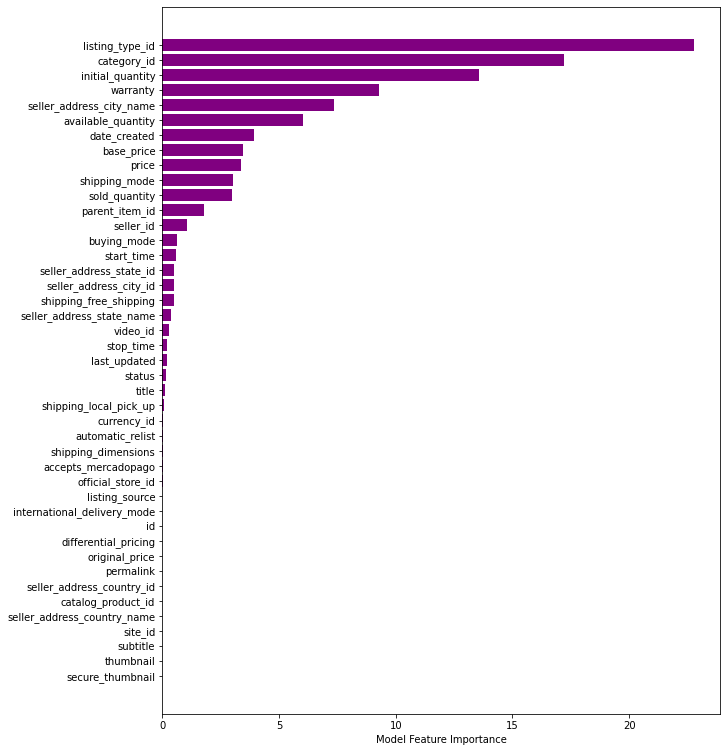

In [30]:
sorted_feature_importance = model.feature_importances_.argsort()

plt.figure(figsize = (10,13))
plt.barh(X_train_2_sorted.columns[sorted_feature_importance],
        model.feature_importances_[sorted_feature_importance], 
        color='purple')

plt.xlabel("Model Feature Importance")

## Model Evaluation

In [31]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [32]:
predictions_probs = model.predict_proba(X_test_2_sorted)

In [33]:
# Print metrics
print("Classification report")

test_pred = np.argmax(predictions_probs, axis=1)

print(classification_report(y_test, test_pred, target_names=list(map(lambda x: str(x),np.unique(y_test)))))

print("Confusion matrix")
print(metrics.confusion_matrix(y_test, test_pred))
print("")


Classification report
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      5406
           1       0.89      0.92      0.91      4594

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Confusion matrix
[[4875  531]
 [ 345 4249]]



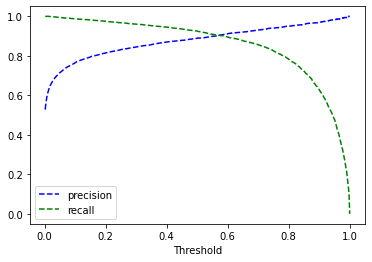

<Figure size 432x288 with 0 Axes>

In [34]:
# Precision - Recall 

def plot_prec_recall_vs_tresh(precision, recall, threshold):
    
    plt.plot(threshold, precision[:-1], 'b--', label='precision')
    plt.plot(threshold, recall[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()
    
    return plt.figure()


precision, recall, threshold = precision_recall_curve(y_test, predictions_probs[:,1])

fig = plot_prec_recall_vs_tresh(precision, recall, threshold)
plt.show(fig)

AUC: 0.9711387249143997


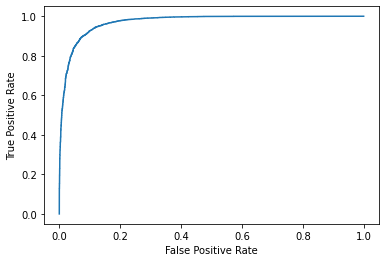

In [35]:
## ROC AUC

fpr, tpr, _ = roc_curve(y_test, predictions_probs[:,1])

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print(f"AUC: {roc_auc_score(y_test, predictions_probs[:,1])}")

## Hyperparameter Optimization

In [36]:
grid = {'iterations': [200, 300, 400],
        'learning_rate': [0.05, 0.1, 0.2],
        'depth': [2, 4, 6],
        'l2_leaf_reg': [0.2, 0.5, 1]}

In [37]:
search = GridSearchCV(model, grid)

search.fit(X_train_2_sorted, 
           y_train, 
           eval_set=(X_test_2_sorted, y_test),
           plot = True, 
           verbose = False,
           cat_features=categorical_features_indices)

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",search.best_estimator_)
print("\n The best score across ALL searched params:\n",search.best_score_)
print("\n The best parameters across ALL searched params:\n",search.best_params_)

## Export the Model 

In [48]:
from joblib import dump, load
dump(model, 'MeLi-challenge-20220628.joblib')

['MeLi-challenge-20220628.joblib']

In [49]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [61]:
%%shell
jupyter nbconvert --to html ///content/meli_challenge.ipynb

[NbConvertApp] Converting notebook ///content/meli_challenge.ipynb to html
[NbConvertApp] Writing 657382 bytes to ///content/meli_challenge.html
